In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### random forest

In [2]:
def RandomForestC(train_x, test_x, train_y, test_y, config):
    
    clf = RandomForestClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def RandomForestR(train_x, test_x, train_y, test_y, config):
    
    clf = RandomForestRegressor(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def runall_ForestC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = RandomForestC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_ForestR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = RandomForestR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def RandomForest_creator(train_data, mode, num_valid = 3, label = 'GB') :
    
    def objective(trial) :

        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800, step = 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 32, step = 5),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3),
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = RandomForestC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 0.75
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                result_list.append(fscore)

            elif mode == 'R':
                result = RandomForestR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1928, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1514, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1662, 88)  balance ratio: 0.71
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (3150, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2480, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 50, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_RandomForest', 
                                     creator = RandomForest_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 12:21:58,920] A new study created in memory with name: no-name-fa879ea1-e59f-483a-bb1a-7116ab2282cc


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:22:09,362] Trial 0 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:22:36,390] Trial 1 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:22:44,462] Trial 2 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:23:22,572] Trial 3 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:23:38,340] Trial 4 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:24:09,678] Trial 5 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:25:02,243] Trial 6 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:25:21,485] Trial 7 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:25:37,085] Trial 8 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:26:45,384] Trial 9 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:27:12,525] Trial 10 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:27:21,971] Trial 11 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:27:46,182] Trial 12 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:28:00,556] Trial 13 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 0.5 
Recall: 0.02631578947368421 
Aging Rate: 0.00010181484969582814
[I 2021-12-13 12:28:58,757] Trial 14 finished with value: 0.05746386924500627 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 14 with value: 0.05746386924500627.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:29:13,930] Trial 15 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:30:00,210] Trial 16 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:30:42,353] Trial 17 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:30:54,841] Trial 18 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:31:22,305] Trial 19 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:32:10,769] Trial 20 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:32:31,775] Trial 21 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 12:33:29,383] Trial 22 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:34:23,676] Trial 23 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:34:38,918] Trial 24 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:34:57,884] Trial 25 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:36:13,147] Trial 26 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:36:55,527] Trial 27 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:38:12,156] Trial 28 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 12:39:12,767] Trial 29 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:39:37,098] Trial 30 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 12:39:50,866] Trial 31 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:40:04,197] Trial 32 failed, because the objective function returned nan.
Precision: 0.8297872340425532 
Recall: 0.5131578947368421 
Aging Rate: 0.0011963244839259806
Precision: 0.9545454545454546 
Recall: 0.5526315789473685 
Aging Rate: 0.0011199633466541096
Precision: 0.8604651162790697 
Recall: 0.4868421052631579 
Aging Rate: 0.0010945096342301526
[I 2021-12-13 12:40:42,481] Trial 33 finished with value: 0.7032172533054157 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 33 with value: 0.7032172533054157.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:41:17,427] Trial 34 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:41:34,834] Trial 35 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:42:41,997] Trial 36 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:43:08,472] Trial 37 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:43:55,285] Trial 38 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.8571428571428571 
Recall: 0.07894736842105263 
Aging Rate: 0.00017817598696769923
[W 2021-12-13 12:44:49,294] Trial 39 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:45:34,926] Trial 40 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.0001527222745437422
[I 2021-12-13 12:46:50,932] Trial 41 finished with value: 0.1215330369785906 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 33 with value: 0.7032172533054157.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:47:23,910] Trial 42 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:48:16,898] Trial 43 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:48:58,859] Trial 44 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:49:22,602] Trial 45 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.00010181484969582814
[W 2021-12-13 12:50:05,348] Trial 46 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:50:21,563] Trial 47 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:51:10,609] Trial 48 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:51:50,140] Trial 49 failed, because the objective function returned nan.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 12:51:50,297] A new study created in memory with name: no-name-e1754d54-45c1-4b5c-bd7b-78c0020a2687


Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9907651715039578 
Recall: 0.9791395045632334 
Aging Rate: 0.4941329856584094
Precision: 0.9803664921465969 
Recall: 0.9765319426336375 
Aging Rate: 0.4980443285528031
Precision: 0.9790301441677588 
Recall: 0.9739243807040417 
Aging Rate: 0.4973924380704042
[I 2021-12-13 12:51:56,353] Trial 0 finished with value: 0.9809055890957717 and parameters: {'n_estimators': 600, 'min_samples_split': 7, 'max_depth': 9}. Best is trial 0 with value: 0.9809055890957717.
Precision: 0.881491344873502 
Recall: 0.863102998696219 
Aging Rate: 0.4895697522816167
Precision: 0.8879892037786775 
Recall: 0.8578878748370273 
Aging Rate: 0.4830508474576271
Precision: 0.8594377510040161 
Recall: 0.8370273794002607 
Aging Rate: 0.4869621903520209
[I 2021-12-13 12:52:00,405] Trial 1 finished with value: 0.8676424917546507 and parameters: {'n_estimators': 400, 'min_samples_split': 27, 'max_depth': 3}. Best is trial 0 with value: 0.9809055890957717.
Precision: 0.8710562414266118 
Recall: 0.82790091264667

Precision: 0.9703989703989704 
Recall: 0.9830508474576272 
Aging Rate: 0.5065189048239895
Precision: 0.9815059445178336 
Recall: 0.9687092568448501 
Aging Rate: 0.4934810951760104
Precision: 0.9855263157894737 
Recall: 0.9765319426336375 
Aging Rate: 0.4954367666232073
[I 2021-12-13 12:53:03,147] Trial 17 finished with value: 0.9780152154788677 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 12}. Best is trial 12 with value: 0.9943093479322579.
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9986859395532195 
Recall: 0.9908735332464146 
Aging Rate: 0.49608865710560623
Precision: 0.9973753280839895 
Recall: 0.9908735332464146 
Aging Rate: 0.49674054758800523
[I 2021-12-13 12:53:08,594] Trial 18 finished with value: 0.9945123344640309 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 18 with value: 0.9945123344640309.
Precision: 0.9947575360419397 
Recall: 0.98956975228161

Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
[I 2021-12-13 12:54:34,398] Trial 34 finished with value: 0.9951806161815568 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 31 with value: 0.9970040227307345.
Precision: 0.9973890339425587 
Recall: 0.9960886571056062 
Aging Rate: 0.49934810951760106
Precision: 0.9973544973544973 
Recall: 0.9830508474576272 
Aging Rate: 0.49282920469361147
Precision: 0.9947437582128777 
Recall: 0.9869621903520208 
Aging Rate: 0.49608865710560623
[I 2021-12-13 12:54:40,384] Trial 35 finished with value: 0.9936687624783122 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 31 with value: 0.9970040227307345.
Precision: 0.9803407601572739 
Recall: 0.9752281616688396 
Aging Rate: 0.4973924380704042
Precision: 0.979002624671916 
Recall: 0.97262

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 12:55:45,264] A new study created in memory with name: no-name-035c617e-0d86-46fd-b16b-6e6b6639e59d


Precision: 0.97911227154047 
Recall: 0.9778357235984355 
Aging Rate: 0.49934810951760106
[I 2021-12-13 12:55:45,124] Trial 49 finished with value: 0.977829294609761 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 9}. Best is trial 31 with value: 0.9970040227307345.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9705882352941176 
Recall: 0.94106463878327 
Aging Rate: 0.4847908745247148
Precision: 0.9555555555555556 
Recall: 0.9401140684410646 
Aging Rate: 0.4919201520912547
Precision: 0.9558823529411765 
Recall: 0.9268060836501901 
Aging Rate: 0.4847908745247148
[I 2021-12-13 12:55:49,724] Trial 0 finished with value: 0.951631440377211 and parameters: {'n_estimators': 400, 'min_samples_split': 17, 'max_depth': 9}. Best is trial 0 with value: 0.951631440377211.
Precision: 0.7947882736156352 
Recall: 0.6958174904942965 
Aging Rate: 0.4377376425855513
Precision: 0.7922912205567452 
Recall: 0.7034220532319392 
Aging Rate: 0.4439163498098859
Precision: 0.7921406411582212 
Recall: 0.7281368821292775 
Aging Rate: 0.45960076045627374
[I 2021-12-13 12:55:56,034] Trial 1 finished with value: 0.7605800733497962 and parameters: {'n_estimators': 700, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 0 with value: 0.951631440377211.
Precision: 0.9858088930936613 
Recall: 0.990494296577946

Precision: 0.9840674789128397 
Recall: 0.9980988593155894 
Aging Rate: 0.5071292775665399
Precision: 0.9886255924170616 
Recall: 0.9914448669201521 
Aging Rate: 0.501425855513308
Precision: 0.9849624060150376 
Recall: 0.9961977186311787 
Aging Rate: 0.5057034220532319
[I 2021-12-13 12:57:14,686] Trial 17 finished with value: 0.9892298613616469 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9903121313154376.
Precision: 0.7771966527196653 
Recall: 0.7062737642585551 
Aging Rate: 0.4543726235741445
Precision: 0.7937701396348013 
Recall: 0.7024714828897338 
Aging Rate: 0.44249049429657794
Precision: 0.7887473460721869 
Recall: 0.7062737642585551 
Aging Rate: 0.44771863117870725
[I 2021-12-13 12:57:18,975] Trial 18 finished with value: 0.7550997162635769 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 10 with value: 0.9903121313154376.
Precision: 0.962890625 
Recall: 0.93726235741444

Precision: 0.9813084112149533 
Recall: 0.9980988593155894 
Aging Rate: 0.5085551330798479
Precision: 0.9867924528301887 
Recall: 0.9942965779467681 
Aging Rate: 0.5038022813688213
Precision: 0.9859287054409006 
Recall: 0.9990494296577946 
Aging Rate: 0.5066539923954373
[I 2021-12-13 12:58:37,820] Trial 34 finished with value: 0.989126875811464 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 32 with value: 0.9925165589694459.
Precision: 0.9725638599810785 
Recall: 0.9771863117870723 
Aging Rate: 0.5023764258555133
Precision: 0.9753320683111955 
Recall: 0.9771863117870723 
Aging Rate: 0.5009505703422054
Precision: 0.9642521166509878 
Recall: 0.9743346007604563 
Aging Rate: 0.5052281368821293
[I 2021-12-13 12:58:40,574] Trial 35 finished with value: 0.9726931211037998 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 15}. Best is trial 32 with value: 0.9925165589694459.
Precision: 0.9803921568627451 
Recall: 0.9980988

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:00:07,414] A new study created in memory with name: no-name-eeb8860c-039c-4f9e-87da-6febaf0af29b


Precision: 0.9868049010367578 
Recall: 0.9952471482889734 
Aging Rate: 0.504277566539924
[I 2021-12-13 13:00:07,242] Trial 49 finished with value: 0.9877250687250981 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 32 with value: 0.9925165589694459.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9412470023980816 
Aging Rate: 0.4706235011990408
Precision: 1.0 
Recall: 0.9364508393285371 
Aging Rate: 0.46822541966426856
Precision: 1.0 
Recall: 0.9412470023980816 
Aging Rate: 0.4706235011990408
[I 2021-12-13 13:00:09,357] Trial 0 finished with value: 0.9773991453640444 and parameters: {'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 0 with value: 0.9773991453640444.
Precision: 1.0 
Recall: 0.9244604316546763 
Aging Rate: 0.46223021582733814
Precision: 1.0 
Recall: 0.9280575539568345 
Aging Rate: 0.46402877697841727
Precision: 1.0 
Recall: 0.9484412470023981 
Aging Rate: 0.47422062350119903
[I 2021-12-13 13:00:10,911] Trial 1 finished with value: 0.9750268019892768 and parameters: {'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 0 with value: 0.9773991453640444.
Precision: 1.0 
Recall: 0.9148681055155875 
Aging Rate: 0.45743405275779375
Precision: 1.0 
Recall: 0.9016786570743405 
Aging Rate: 0.4508

Precision: 1.0 
Recall: 0.89568345323741 
Aging Rate: 0.447841726618705
Precision: 1.0 
Recall: 0.9016786570743405 
Aging Rate: 0.45083932853717024
Precision: 1.0 
Recall: 0.9172661870503597 
Aging Rate: 0.45863309352517984
[I 2021-12-13 13:01:18,213] Trial 19 finished with value: 0.9635125095593488 and parameters: {'n_estimators': 200, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 10 with value: 0.9934470337558134.
Precision: 1.0 
Recall: 0.9748201438848921 
Aging Rate: 0.48741007194244607
Precision: 0.9975550122249389 
Recall: 0.9784172661870504 
Aging Rate: 0.4904076738609113
Precision: 0.997539975399754 
Recall: 0.9724220623501199 
Aging Rate: 0.48741007194244607
[I 2021-12-13 13:01:22,309] Trial 20 finished with value: 0.9899053267290391 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9934470337558134.
Precision: 1.0 
Recall: 0.9520383693045563 
Aging Rate: 0.47601918465227816
Precision: 1.0 
Recall: 0.961630

Precision: 1.0 
Recall: 0.9724220623501199 
Aging Rate: 0.4862110311750599
[I 2021-12-13 13:02:21,622] Trial 37 finished with value: 0.9903398243586269 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9934470337558134.
Precision: 1.0 
Recall: 0.9220623501199041 
Aging Rate: 0.46103117505995206
Precision: 1.0 
Recall: 0.9460431654676259 
Aging Rate: 0.47302158273381295
Precision: 1.0 
Recall: 0.9280575539568345 
Aging Rate: 0.46402877697841727
[I 2021-12-13 13:02:24,073] Trial 38 finished with value: 0.974400304521509 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 10 with value: 0.9934470337558134.
Precision: 1.0 
Recall: 0.9916067146282974 
Aging Rate: 0.4958033573141487
Precision: 0.9975429975429976 
Recall: 0.973621103117506 
Aging Rate: 0.4880095923261391
Precision: 1.0 
Recall: 0.9784172661870504 
Aging Rate: 0.4892086330935252
[I 2021-12-13 13:02:26,767] Trial 39 finished 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:02:51,592] A new study created in memory with name: no-name-7a61a3c2-fa02-4616-ba5e-28d1a0b683c0


Precision: 1.0 
Recall: 0.9160671462829736 
Aging Rate: 0.4580335731414868
[I 2021-12-13 13:02:51,436] Trial 49 finished with value: 0.9670510127549082 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 9}. Best is trial 10 with value: 0.9934470337558134.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9902642559109874 
Recall: 0.9368421052631579 
Aging Rate: 0.4730263157894737
Precision: 0.9916666666666667 
Recall: 0.9394736842105263 
Aging Rate: 0.47368421052631576
Precision: 0.9825970548862115 
Recall: 0.9657894736842105 
Aging Rate: 0.49144736842105263
[I 2021-12-13 13:02:57,916] Trial 0 finished with value: 0.9730153673197052 and parameters: {'n_estimators': 700, 'min_samples_split': 17, 'max_depth': 9}. Best is trial 0 with value: 0.9730153673197052.
Precision: 0.9958391123439667 
Recall: 0.9447368421052632 
Aging Rate: 0.4743421052631579
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
Precision: 0.9959128065395095 
Recall: 0.9618421052631579 
Aging Rate: 0.48289473684210527
[I 2021-12-13 13:03:04,517] Trial 1 finished with value: 0.981918982698291 and parameters: {'n_estimators': 700, 'min_samples_split': 17, 'max_depth': 12}. Best is trial 1 with value: 0.981918982698291.
Precision: 0.9493670886075949 
Recall: 0.88815789

Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
Precision: 0.9972826086956522 
Recall: 0.9657894736842105 
Aging Rate: 0.4842105263157895
[I 2021-12-13 13:04:22,093] Trial 17 finished with value: 0.9884558834984377 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 12 with value: 0.9919533991728077.
Precision: 0.9986301369863013 
Recall: 0.9592105263157895 
Aging Rate: 0.48026315789473684
Precision: 0.9959183673469387 
Recall: 0.9631578947368421 
Aging Rate: 0.48355263157894735
Precision: 0.9932065217391305 
Recall: 0.9618421052631579 
Aging Rate: 0.4842105263157895
[I 2021-12-13 13:04:27,478] Trial 18 finished with value: 0.9832082219205072 and parameters: {'n_estimators': 500, 'min_samples_split': 32, 'max_depth': 15}. Best is trial 12 with value: 0.9919533991728077.
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 


Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
[I 2021-12-13 13:05:47,718] Trial 34 finished with value: 0.9913078610139653 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 22 with value: 0.9938183493953009.
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
[I 2021-12-13 13:05:52,725] Trial 35 finished with value: 0.9895128328222921 and parameters: {'n_estimators': 600, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 22 with value: 0.9938183493953009.
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
[I 2021-12-13 13:06:00,

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:06:57,039] A new study created in memory with name: no-name-d958e590-350d-46d8-b6b9-f628af3a7205


Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
[I 2021-12-13 13:06:56,993] Trial 49 finished with value: 0.9874731673379604 and parameters: {'n_estimators': 400, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 47 with value: 0.9942956260351968.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9934123847167325 
Recall: 0.9986754966887417 
Aging Rate: 0.500990099009901
Precision: 0.9973118279569892 
Recall: 0.9827814569536424 
Aging Rate: 0.4910891089108911
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2021-12-13 13:06:58,313] Trial 0 finished with value: 0.9940114494855342 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 0 with value: 0.9940114494855342.
Precision: 0.9892761394101877 
Recall: 0.9774834437086093 
Aging Rate: 0.4924092409240924
Precision: 0.9906040268456375 
Recall: 0.9774834437086093 
Aging Rate: 0.49174917491749176
Precision: 0.9853723404255319 
Recall: 0.9814569536423841 
Aging Rate: 0.49636963696369635
[I 2021-12-13 13:06:59,609] Trial 1 finished with value: 0.9849325246888343 and parameters: {'n_estimators': 200, 'min_samples_split': 22, 'max_depth': 12}. Best is trial 0 with value: 0.9940114494855342.
Precision: 0.9920212765957447 
Recall: 0.98807947

Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.99734395750332 
Recall: 0.9947019867549669 
Aging Rate: 0.497029702970297
[I 2021-12-13 13:07:43,441] Trial 17 finished with value: 0.994502897709773 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 13 with value: 0.9948703112211689.
Precision: 0.9986702127659575 
Recall: 0.9947019867549669 
Aging Rate: 0.49636963696369635
Precision: 0.9986595174262735 
Recall: 0.9867549668874173 
Aging Rate: 0.4924092409240924
Precision: 0.9986666666666667 
Recall: 0.9920529801324504 
Aging Rate: 0.49504950495049505
[I 2021-12-13 13:07:47,527] Trial 18 finished with value: 0.9959515155335907 and parameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 18 with value: 0.9959515155335907.
Precision: 0.9880159786950732 
Recall: 0.982781456

Precision: 1.0 
Recall: 0.9867549668874173 
Aging Rate: 0.49174917491749176
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
[I 2021-12-13 13:08:34,478] Trial 34 finished with value: 0.9926586445735478 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 32 with value: 0.9965963022952441.
Precision: 0.9893617021276596 
Recall: 0.9854304635761589 
Aging Rate: 0.49636963696369635
Precision: 1.0 
Recall: 0.9880794701986755 
Aging Rate: 0.4924092409240924
Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
[I 2021-12-13 13:08:38,367] Trial 35 finished with value: 0.9918483181835329 and parameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 32 with value: 0.9965963022952441.
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.4983

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:09:18,525] A new study created in memory with name: no-name-7810dae3-b665-4c50-8062-65c18db374c4


Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
[I 2021-12-13 13:09:18,482] Trial 49 finished with value: 0.9933387245371955 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 32 with value: 0.9965963022952441.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.8377049180327869 
Recall: 0.9668874172185431 
Aging Rate: 0.6714364336818932
Precision: 0.8407590759075908 
Recall: 0.9640491958372753 
Aging Rate: 0.6670335718216841
Precision: 0.8405560098119379 
Recall: 0.9725638599810785 
Aging Rate: 0.6730875068794716
[I 2021-12-13 13:09:20,913] Trial 0 finished with value: 0.8817023327849894 and parameters: {'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 6}. Best is trial 0 with value: 0.8817023327849894.
Precision: 0.9722479185938946 
Recall: 0.9943235572374646 
Aging Rate: 0.5949367088607594
Precision: 0.9571558796718322 
Recall: 0.9933774834437086 
Aging Rate: 0.6037424325811778
Precision: 0.974907063197026 
Recall: 0.9924314096499527 
Aging Rate: 0.5921849201981287
[I 2021-12-13 13:09:23,858] Trial 1 finished with value: 0.977037566676923 and parameters: {'n_estimators': 600, 'min_samples_split': 32, 'max_depth': 18}. Best is trial 1 with value: 0.977037566676923.
Precision: 0.9351351351351351 
Recall: 0.9820245979186

Precision: 0.8311688311688312 
Recall: 0.9687795648060549 
Aging Rate: 0.6780407264722069
Precision: 0.8167330677290837 
Recall: 0.9697256385998108 
Aging Rate: 0.6906989543203081
Precision: 0.833605220228385 
Recall: 0.9668874172185431 
Aging Rate: 0.6747385800770501
[I 2021-12-13 13:10:03,239] Trial 17 finished with value: 0.8730031172556606 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 6}. Best is trial 12 with value: 0.9901440760769701.
Precision: 0.9786245353159851 
Recall: 0.9962157048249763 
Aging Rate: 0.5921849201981287
Precision: 0.9850606909430439 
Recall: 0.9981078524124882 
Aging Rate: 0.589433131535498
Precision: 0.9868791002811621 
Recall: 0.9962157048249763 
Aging Rate: 0.5872317006053935
[I 2021-12-13 13:10:05,858] Trial 18 finished with value: 0.9882745225797892 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 12 with value: 0.9901440760769701.
Precision: 0.9794584500466853 
Recall: 0.992431409

Precision: 0.9850327408793265 
Recall: 0.9962157048249763 
Aging Rate: 0.5883324160704458
Precision: 0.9849906191369606 
Recall: 0.9933774834437086 
Aging Rate: 0.5866813428728673
Precision: 0.9896519285042333 
Recall: 0.9952696310312205 
Aging Rate: 0.5850302696752889
[I 2021-12-13 13:10:59,258] Trial 34 finished with value: 0.9895633582475698 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 30 with value: 0.991015667257262.
Precision: 0.9813780260707635 
Recall: 0.9971617786187322 
Aging Rate: 0.5910842047330765
Precision: 0.9777777777777777 
Recall: 0.9990539262062441 
Aging Rate: 0.5943863511282333
Precision: 0.983177570093458 
Recall: 0.9952696310312205 
Aging Rate: 0.5888827738029719
[I 2021-12-13 13:11:03,304] Trial 35 finished with value: 0.9866103297339707 and parameters: {'n_estimators': 800, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 30 with value: 0.991015667257262.
Precision: 0.9711359404096834 
Recall: 0.986754966

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:11:42,600] A new study created in memory with name: no-name-752617c2-5d9d-4734-84cc-fc174c1af21a


Precision: 0.9795158286778398 
Recall: 0.9952696310312205 
Aging Rate: 0.5910842047330765
[I 2021-12-13 13:11:42,553] Trial 49 finished with value: 0.9872510503314444 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 30 with value: 0.991015667257262.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9171052631578948 
Aging Rate: 0.4585526315789474
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
Precision: 0.9971181556195965 
Recall: 0.9105263157894737 
Aging Rate: 0.45657894736842103
[I 2021-12-13 13:11:43,425] Trial 0 finished with value: 0.9672034438793421 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 18}. Best is trial 0 with value: 0.9672034438793421.
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2021-12-13 13:11:45,961] Trial 1 finished with value: 0.964403071401308 and parameters: {'n_estimators': 600, 'min_samples_split': 27, 'max_depth': 9}. Best is trial 0 with value: 0.9672034438793421.
Precision: 0.9985754985754985 
Recall: 0.9223684210526316 
Aging Rate: 0.4618421052631579
Precision: 0.9985915492957746 
Re

Precision: 1.0 
Recall: 0.9328947368421052 
Aging Rate: 0.4664473684210526
Precision: 1.0 
Recall: 0.9263157894736842 
Aging Rate: 0.4631578947368421
[I 2021-12-13 13:12:16,042] Trial 18 finished with value: 0.9745794183112749 and parameters: {'n_estimators': 600, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 12 with value: 0.9904049851561584.
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.4842105263157895
Precision: 0.9986468200270636 
Recall: 0.9710526315789474 
Aging Rate: 0.4861842105263158
[I 2021-12-13 13:12:16,920] Trial 19 finished with value: 0.9886070785530814 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 12 with value: 0.9904049851561584.
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
Precision: 1.0 
Recall: 0.9118421052631579 
A

Precision: 1.0 
Recall: 0.9039473684210526 
Aging Rate: 0.4519736842105263
[I 2021-12-13 13:12:47,583] Trial 36 finished with value: 0.9631403608584609 and parameters: {'n_estimators': 200, 'min_samples_split': 17, 'max_depth': 3}. Best is trial 27 with value: 0.990733794064162.
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.4842105263157895
[I 2021-12-13 13:12:49,630] Trial 37 finished with value: 0.9876622473081844 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 27 with value: 0.990733794064162.
Precision: 0.9986468200270636 
Recall: 0.9710526315789474 
Aging Rate: 0.4861842105263158
Precision: 0.9986320109439124 
Recall: 0.9605263157894737 
Aging Rate: 0.48092105263157897
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.4842105263157895
[I 2021-12-13 13:12:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:13:10,530] A new study created in memory with name: no-name-4b3b1723-9223-4ad5-a79f-287969fec3b8


Precision: 1.0 
Recall: 0.9328947368421052 
Aging Rate: 0.4664473684210526
[I 2021-12-13 13:13:10,483] Trial 49 finished with value: 0.9757748597061315 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 42 with value: 0.9910082017909533.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9945578231292517 
Recall: 0.9618421052631579 
Aging Rate: 0.48355263157894735
Precision: 0.9986244841815681 
Recall: 0.9552631578947368 
Aging Rate: 0.47828947368421054
Precision: 1.0 
Recall: 0.9592105263157895 
Aging Rate: 0.47960526315789476
[I 2021-12-13 13:13:11,381] Trial 0 finished with value: 0.9833390906852202 and parameters: {'n_estimators': 100, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 0 with value: 0.9833390906852202.
Precision: 0.9986376021798365 
Recall: 0.9644736842105263 
Aging Rate: 0.48289473684210527
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2021-12-13 13:13:12,271] Trial 1 finished with value: 0.986930153832699 and parameters: {'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 1 with value: 0.986930153832699.
Precision: 0.9931880108991825 
Recall: 0.9592105263157895 
Aging Rate: 0.482

Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2021-12-13 13:13:58,778] Trial 17 finished with value: 0.991217970907309 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 16 with value: 0.9919625623348916.
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2021-12-13 13:14:01,745] Trial 18 finished with value: 0.9937755694125414 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 18 with value: 0.9937755694125414.
Precision: 0.8312236286919831 
Recall: 0.7776315789473685 
Aging Rate: 0.4677631578947368
Precision: 0.8510928961748634 
Recall: 0.8197368421052632 
Aging Rate: 0.48157894736842105
Precision: 0.8423988842398884 
Recall: 0.7947368421052632 
Aging Rate: 0.4717

Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2021-12-13 13:14:26,255] Trial 35 finished with value: 0.9929241442464317 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 18 with value: 0.9937755694125414.
Precision: 1.0 
Recall: 0.9526315789473684 
Aging Rate: 0.4763157894736842
Precision: 0.9986206896551724 
Recall: 0.9526315789473684 
Aging Rate: 0.4769736842105263
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
[I 2021-12-13 13:14:27,500] Trial 36 finished with value: 0.9833941969415525 and parameters: {'n_estimators': 200, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 18 with value: 0.9937755694125414.
Precision: 1.0 
Recall: 0.9671052631578947 
Aging Rate: 0.4

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:14:47,289] A new study created in memory with name: no-name-7aae44b2-bd8d-4bd2-ae2a-75b55bab8dc2


Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
[I 2021-12-13 13:14:47,242] Trial 49 finished with value: 0.9922229634461264 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 18 with value: 0.9937755694125414.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2021-12-13 13:14:48,963] Trial 0 finished with value: 0.1005952891842515 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 0 with value: 0.1005952891842515.
Precision: 1.0 
Recall: 0.2631578947368421 
Aging Rate: 0.023923444976076555
Precision: 0.9375 
Recall: 0.19736842105263158 
Aging Rate: 0.019138755980861243
Precision: 0.9285714285714286 
Recall: 0.17105263157894737 
Aging Rate: 0.01674641148325359
[I 2021-12-13 13:14:51,178] Trial 1 finished with value: 0.41829121791958607 and parameters: {'n_estimators': 500, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 1 with value: 0.41829121791958607.
Precision: 1.0 
Recall: 0.5657894736842105 
Aging Rate: 0.05143540669856459
Precision: 0.95 
Recall: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:14:54,563] Trial 3 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:14:55,430] Trial 4 failed, because the objective function returned nan.
Precision: 0.9375 
Recall: 0.19736842105263158 
Aging Rate: 0.019138755980861243
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 0.8461538461538461 
Recall: 0.14473684210526316 
Aging Rate: 0.01555023923444976
[I 2021-12-13 13:14:58,005] Trial 5 finished with value: 0.3344802217146712 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 2 with value: 0.7175053844829592.
Precision: 1.0 
Recall: 0.19736842105263158 
Aging Rate: 0.017942583732057416
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.008373205741626795
Precision: 0.7647058823529411 
Recall: 0.17105263157894737 
Aging Rate: 0.02033492822966507
[I 2021-12-13 13:14:59,656] Trial 6 finished with value: 0.3218838536903758 and parameters: {'n_estimators': 300, 'min_samples_split': 32, 'max_depth': 18}. Best is 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:15:04,563] Trial 8 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.42105263157894735 
Aging Rate: 0.03827751196172249
Precision: 1.0 
Recall: 0.4473684210526316 
Aging Rate: 0.04066985645933014
Precision: 0.9117647058823529 
Recall: 0.40789473684210525 
Aging Rate: 0.04066985645933014
[I 2021-12-13 13:15:07,060] Trial 9 finished with value: 0.6640620744501216 and parameters: {'n_estimators': 600, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 2 with value: 0.7175053844829592.
Precision: 1.0 
Recall: 0.4868421052631579 
Aging Rate: 0.04425837320574163
Precision: 0.9523809523809523 
Recall: 0.5263157894736842 
Aging Rate: 0.050239234449760764
Precision: 1.0 
Recall: 0.5789473684210527 
Aging Rate: 0.05263157894736842
[I 2021-12-13 13:15:09,997] Trial 10 finished with value: 0.7516306538495509 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 10 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:15:15,898] Trial 13 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:15:16,764] Trial 14 failed, because the objective function returned nan.
Precision: 0.8947368421052632 
Recall: 0.2236842105263158 
Aging Rate: 0.022727272727272728
Precision: 1.0 
Recall: 0.2894736842105263 
Aging Rate: 0.02631578947368421
Precision: 0.9523809523809523 
Recall: 0.2631578947368421 
Aging Rate: 0.025119617224880382
[I 2021-12-13 13:15:19,735] Trial 15 finished with value: 0.4837486842130805 and parameters: {'n_estimators': 800, 'min_samples_split': 22, 'max_depth': 18}. Best is trial 10 with value: 0.7516306538495509.
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
Precision: 0.9508196721311475 
Recall: 0.7631578947368421 
Aging Rate: 0.0729665071770335
Precision: 0.9622641509433962 
Recall: 0.6710526315789473 
Aging Rate: 0.06339712918660287
[I 2021-12-13 13:15:21,690] Trial 16 finished with value: 0.8684143762657938 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max

Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
[I 2021-12-13 13:15:48,527] Trial 33 finished with value: 0.9188036499115003 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 33 with value: 0.9188036499115003.
Precision: 1.0 
Recall: 0.8026315789473685 
Aging Rate: 0.0729665071770335
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
[I 2021-12-13 13:15:51,316] Trial 34 finished with value: 0.9206448405830185 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9206448405830185.
Precision: 1.0 
Recall: 0.6973684210526315 
Aging Rate: 0.06339712918660287
Precision: 0.9666666666666667 
Recall: 0.7

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:15:58,004] Trial 37 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
Precision: 0.9649122807017544 
Recall: 0.7236842105263158 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
[I 2021-12-13 13:16:00,577] Trial 38 finished with value: 0.8911471010878643 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9206448405830185.
Precision: 1.0 
Recall: 0.631578947368421 
Aging Rate: 0.05741626794258373
Precision: 1.0 
Recall: 0.618421052631579 
Aging Rate: 0.056220095693779906
Precision: 1.0 
Recall: 0.5921052631578947 
Aging Rate: 0.05382775119617225
[I 2021-12-13 13:16:03,500] Trial 39 finished with value: 0.8153244858739921 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 34 with value: 0.920

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:16:05,646] Trial 40 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2021-12-13 13:16:07,864] Trial 41 finished with value: 0.9059773790760369 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9206448405830185.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:16:10,876] Trial 42 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7236842105263158 
Aging Rate: 0.06578947368421052
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0645933014354067
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
[I 2021-12-13 13:16:13,775] Trial 43 finished with value: 0.8847278569106808 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 34 with value: 0.9206448405830185.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:16:16,904] Trial 44 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:16:18,612] Trial 45 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.008373205741626795
Precision: 0.7142857142857143 
Recall: 0.06578947368421052 
Aging Rate: 0.008373205741626795
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2021-12-13 13:16:20,326] Trial 46 finished with value: 0.18973070480608167 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 34 with value: 0.9206448405830185.
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.7236842105263158 
Aging Rate: 0.06578947368421052
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2021-12-13 13:16:23,232] Trial 47 finished with value: 0.8905056250572297 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9206448405

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m5_4selection_RandomForest', 
                                     creator = RandomForest_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'RandomForest Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.055540709983761e-05

 Dataset 1:
Precision: 0.0013297872340425532 
Recall: 0.0784313725490196 
Aging Rate: 0.06183066455631154

 Dataset 2:
Precision: 0.0011989209711259865 
Recall: 0.23529411764705882 
Aging Rate: 0.20573906966227465

 Dataset 3:
Precision: 0.0009519276534983341 
Recall: 0.0392156862745098 
Aging Rate: 0.04318691031675882

 Dataset 4:
Precision: 0.0009606147934678194 
Recall: 0.0196078431372549 
Aging Rate: 0.021398178790930953

 Dataset 5:
Precision: 0.0013517166801838335 
Recall: 0.09803921568627451 
Aging Rate: 0.07603445086229933

 Dataset 6:
Precision: 0.001197930846719303 
Recall: 0.43137254901960786 
Aging Rate: 0.3775000513885178

 Dataset 7:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.02583814672449588

 Dataset 8:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.012333244259902567

 Dataset 9:
Precision: 0.000708215297450425 
Recall: 0.0196078431372549 
Aging Rate: 0.02902423482497071


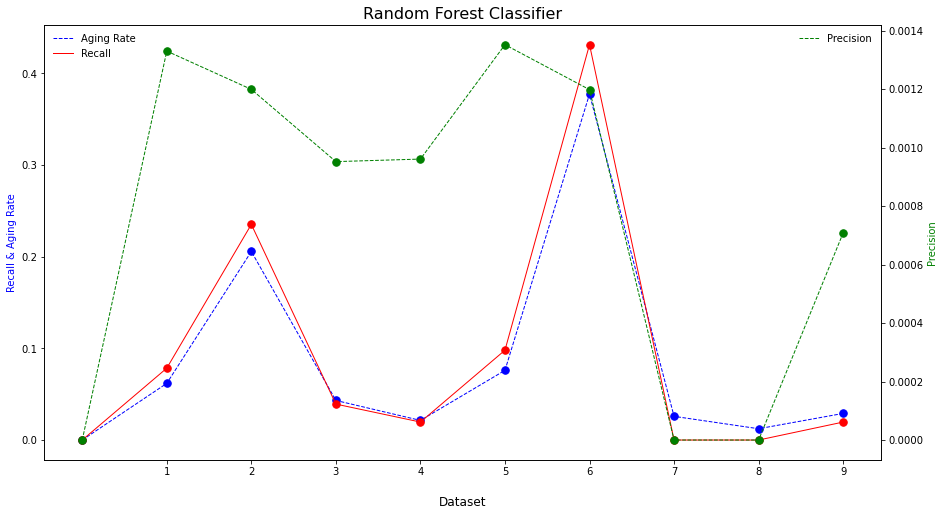

In [6]:
table_setC = runall_ForestC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'Random Forest Classifier')

In [7]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,1.0,51.0,48597.0,0.000000,0.000000,0.000021,0.000000,0.000000
dataset 1,1.000000,3067.0,3067.0,4.0,3004.0,47.0,45594.0,0.001330,0.078431,0.061831,1.268487,0.064244
dataset 2,1.000000,4207.0,4207.0,12.0,9997.0,39.0,38601.0,0.001199,0.235294,0.205739,1.143653,0.179414
dataset 3,1.000000,3336.0,3336.0,2.0,2099.0,49.0,46499.0,0.000952,0.039216,0.043187,0.908046,0.000000
dataset 4,1.000000,3038.0,3038.0,1.0,1040.0,50.0,47558.0,0.000961,0.019608,0.021398,0.916332,0.000000
dataset 5,1.006623,3040.0,3020.0,5.0,3694.0,46.0,44904.0,0.001352,0.098039,0.076034,1.289405,0.081205
dataset 6,0.719016,3040.0,4228.0,22.0,18343.0,29.0,30255.0,0.001198,0.431373,0.377500,1.142709,0.328736
dataset 7,1.000000,3040.0,3040.0,0.0,1257.0,51.0,47341.0,0.000000,0.000000,0.025838,0.000000,0.000000
dataset 8,1.000000,3040.0,3040.0,0.0,600.0,51.0,47998.0,0.000000,0.000000,0.012333,0.000000,0.000000
dataset 9,10.000000,3040.0,304.0,1.0,1411.0,50.0,47187.0,0.000708,0.019608,0.029024,0.675568,0.000000


### Regressor

In [ ]:
pr_dict, table_setR = runall_ForestR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                     thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'Random Forest Regressor')

In [ ]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [8]:
savedate = '20211214'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'RandomForest'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'RandomForest')